In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import community as louvain

from alec_utils import *
from scipy.spatial.distance import squareform
from sklearn.cluster import *
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

In [2]:
df = pd.read_csv("../OCE_test_data/vectorized_oce_data.csv")
print(df.shape)
df.head()

(1285606, 15)


,id_a,id_b,type_a,type_b,time_a,time_b,same_instance,same_parent,share_ancestor,time_delta_seconds,distance_on_graph,distance_in_st,io_id_similarity,io_label_similarity,related
0,4516675,4516676,SnmpInterface,SnmpInterface,1541292527000,1541292527000,1,1,1,0.0,0.000000e+00,0.000000e+00,0.00,-1.0,1
1,4516675,4516678,SnmpInterface,SnmpInterface,1541292527000,1541292592000,0,0,0,65000.0,2.147484e+09,1.388125e+09,0.25,-1.0,0
2,4516675,4516679,SnmpInterface,SnmpInterface,1541292527000,1541292592000,0,0,0,65000.0,2.147484e+09,1.388125e+09,0.25,-1.0,0
3,4516675,4516683,SnmpInterface,SnmpInterface,1541292527000,1541292883000,0,0,0,356000.0,2.147484e+09,1.388125e+09,0.25,-1.0,0
4,4516675,4516684,SnmpInterface,SnmpInterface,1541292527000,1541292883000,0,0,0,356000.0,2.147484e+09,1.388125e+09,0.25,-1.0,0


# Load clusters from ALEC
cpn_situations is the "gold standard"

oce_situations is produced by the ALEC DBSCAN engine

In [6]:
cpn_situations = read_xml_clusters('../OCE_test_data/cpn.situations.xml')
oce_situations = read_xml_clusters('../alec_docker/xml/oce.situations.xml')

# Add singletons into alec clusters

In [7]:
missing_alarms = list(set(cpn_situations['id']).difference(set(oce_situations['id'])))
len(missing_alarms)

99

In [8]:
#alec dbscan doesn't output singletons, so is performance better if we add missing alarms as singletons?
oce_situations_sing = oce_situations.copy()
oce_situations_sing = oce_situations_sing.append(pd.DataFrame({'id':missing_alarms, 'cluster':missing_alarms}))

# Run other clustering algorithms

In [9]:
pairdist = df.loc[:,['id_a', 'id_b', 'distance_in_st']].sort_values(by=['id_a', 'id_b'])
distraw = squareform(pairdist['distance_in_st'])

In [11]:
alarmids = np.unique(pairdist['id_a'].values.tolist() + pairdist['id_b'].values.tolist())
alarmids = [str(x) for x in alarmids]
len(alarmids)

1604

In [12]:
dbscan_clustering = DBSCAN(eps=100,min_samples=1,metric='precomputed').fit(distraw)
dbscan_situations = pd.DataFrame({'id':alarmids, 
                        'cluster':dbscan_clustering.labels_})

In [13]:
G = nx.from_numpy_matrix((distraw < 500)) #& (timemat < 90000))
print(nx.info(G))
louvain_clustering = louvain.best_partition(G)
louvain_situations = pd.DataFrame({'id':alarmids, 
                       'cluster':list(louvain_clustering.values())})

Name: 
Type: Graph
Number of nodes: 1604
Number of edges: 16646
Average degree:  20.7556


# Score cluster assignments against CPN and plot

In [15]:
scoredf = pd.DataFrame([score_clusters(cpn_situations, oce_situations),
                        score_clusters(cpn_situations, oce_situations_sing),
                       score_clusters(cpn_situations, dbscan_situations),
                       score_clusters(cpn_situations, louvain_situations)])
scoredf['alg'] = ['DBSCANoce', 'DBSCANoce_sing','DBSCANpy', 'louvain']

(1505, 2)
(1604, 2)
(1604, 2)
(1604, 2)


In [16]:
scoredf = pd.melt(scoredf, id_vars=['alg'])

Text(12.79251302083334, 0.5, 'Value')

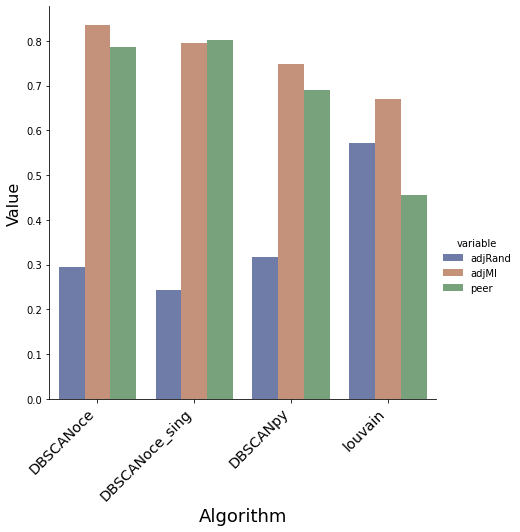

In [17]:
g = sns.catplot(
    data=scoredf, kind="bar",
    x="alg", y="value", hue='variable', palette="dark", alpha=.6, height=6
)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.xlabel('Algorithm', fontsize=18)
plt.ylabel('Value', fontsize=16)

<AxesSubplot:ylabel='Count'>

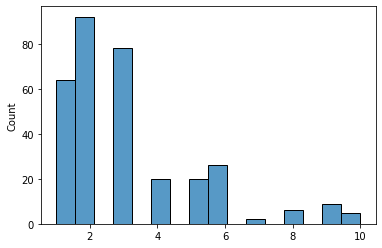

In [18]:
u,c = np.unique(louvain_situations['cluster'], return_counts=True)
#sns.histplot(c)
sns.histplot(c[c<12])

<AxesSubplot:ylabel='Count'>

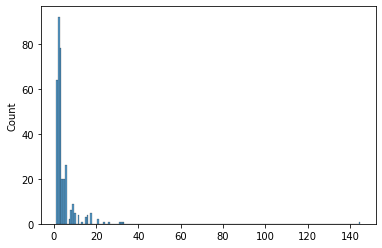

In [19]:
sns.histplot(c)